# Housing - Lineer Regression

sale_price prediction

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

from sklearn.linear_model import LinearRegression

sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 250)


In [42]:
# tuning params for outliers

neighborhood_min_len = 2  # minimum meaningful length

#both min or quantile !
sale_price_min = 1000 # min intuitive sale price, if -1, discarded
sale_price_lq = 0.01  # left quantile
sale_price_rq = 0.99  # right quantile

building_category_mapping = ['FAMILY', 'APARTMENT', 'LUXURY', 'FACILITIES'] # maps building_class_category

total_units_min = 1    # minimum total units - is 0 meanigful?
total_units_max = 10   # maximum total units - treat >10 as outliers

gross_square_feet_min = -1     # if -1, discarded
gross_square_feet_max = 20000  # if -1, discarded
gross_square_feet_lq = 0.01
gross_square_feet_rq = 0.99

year_built_min = 1900


In [43]:
# read all datasets w/ dates

filenames = glob.glob(os.path.join('dataset/housing/', 'r*.csv'))

#
li = []

for filename in filenames:
    df = pd.read_csv(filename, \
                dtype={'YEAR BUILT': object, 'BLOCK': object, 'LOT': object, 'ZIP CODE': object, 
                       'COMMERCIAL UNITS': object,
                       'BOROUGH': object, 'NEIGHBORHOOD': object, 'BUILDING CLASS CATEGORY': object,
                       'TAX CLASS AT PRESENT': object,  'EASE-MENT': object,
                       'BUILDING CLASS AT PRESENT': object, 'ADDRESS': object, 
                       'APART\nMENT\nNUMBER': object,
                       'RESIDENTIAL UNITS': object, 'COMMERCIAL UNITS': object, 'TOTAL UNITS': object,
                       'LAND SQUARE FEET': object, 'GROSS SQUARE FEET': object,
                       'TAX CLASS AT TIME OF SALE': object, 'BUILDING CLASS AT TIME OF SALE': object,
                       'SALE\nPRICE': str}, \
                parse_dates=['SALE DATE'], \
                infer_datetime_format=True)
    li.append(df)


raw_data = pd.concat(li, axis=0, ignore_index=True)


raw_data.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APART MENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09


## Preperations
Apply all gains from _EDA stage

In [61]:
# change columns' order and names

data = raw_data.copy()

data.columns = ['borough', 'neighborhood', 'building_class_category',
                    'tax_class_at_present', 'block', 'lot', 'easement',
                    'building_class_at_present', 'address', 'apartment_number',
                    'zipcode', 'residential_units', 'commercial_units', 'total_units',
                    'land_square_feet', 'gross_square_feet', 'year_built',
                    'tax_class_at_sale', 'building_class_at_sale',
                    'sale_price', 'sale_date']

data.rename(columns={"building_class_category": "building_category"}, inplace=True)


data.head(1)

,borough,neighborhood,building_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09


In [62]:
# Apply all gains from _EDA stage

data['borough'] = data['borough'].map({'1':'Manhattan', '3':'Brooklyn', '2':'Bronx', '4':'Queens', '5':'Staten Island'})  

data['sale_price'] = data['sale_price'].str.replace(r',|\$', '').astype(float)
data['neighborhood'] = data.neighborhood.str.split(r'(\s+)$', expand=True)[0]

#
data['building_category'] = data['building_category'].str.split(r'(\s+)$', expand=True)[0] \
                                                     .str.split(r'(^\S+)(\s+)', expand=True)[3]

for m in building_category_mapping:
    data.loc[data.building_category.str.contains(m, na=False), 'building_category_map'] = m
    
data.loc[data.building_category_map.isna(), 'building_category_map'] = 'OTHER'

#
data.rename(columns={"tax_class_at_present": "tax_class"}, inplace=True)
data.rename(columns={"tax_class_at_sale": "tax_class_map"}, inplace=True)

data['tax_class'] = data['tax_class'].str.replace(r'\s+', '').astype(object)
data['tax_class_map'] = data['tax_class_map'].str.replace(r'\s+', '').astype(object)

#
data.drop(['lot', 'block', 'easement'], axis=1, inplace=True)

#
data.drop(['building_class_at_present'], axis=1, inplace=True)

data.rename(columns={"building_class_at_sale": "building_class"}, inplace=True)

data['building_class'] = data['building_class'].str.replace(r'[^\S+]', '').astype(object)
data['building_class_map'] = data['building_class'].str[0:1]

#
data.drop(['apartment_number', 'address'], axis=1, inplace=True)

#
for col in ('residential_units', 'commercial_units', 'total_units'):
    data[col] = data[col].str.replace(r',', '').astype(int)


data.loc[(data.commercial_units == 0), 'building_type'] = 'RESIDENTIAL'
data.loc[(data.commercial_units > 0) & (data.residential_units == 0), 'building_type'] = 'COMMERCIAL'
data.loc[(data.commercial_units > 0) & (data.residential_units > 0), 'building_type'] = 'COMMERCIAL W/ RESIDENTIAL'

#
for col in ('land_square_feet', 'gross_square_feet'):
    data[col] = data[col].str.replace(r',', '').astype(int)

#
data['sale_month'] = data.sale_date.dt.month.astype(object)
data['sale_year'] = data.sale_date.dt.year.astype(object)



In [63]:
data.head(2)

,borough,neighborhood,building_category,tax_class,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_map,building_class,sale_price,sale_date,building_category_map,building_class_map,building_type,sale_month,sale_year
0,Brooklyn,,CONDOS - 2-10 UNIT RESIDENTIAL,,11220,0,0,0,0,0,0,2,R1,403572.0,2013-07-09,OTHER,R,RESIDENTIAL,7,2013
1,Brooklyn,,CONDOS - 2-10 UNIT RESIDENTIAL,,11220,0,0,0,0,0,0,2,R1,218010.0,2013-07-12,OTHER,R,RESIDENTIAL,7,2013


In [64]:
# change column order, in a meaningful way


data = data[['borough', 'neighborhood', 
             'building_class', 'building_class_map', 
             'building_category', 'building_category_map', 'building_type', 
             'tax_class', 'tax_class_map', 
             'zipcode',
             'residential_units', 'commercial_units', 'total_units',
             'land_square_feet', 'gross_square_feet', 
             'year_built',
             'sale_date', 'sale_month', 'sale_year',
             'sale_price']]

In [65]:
data.head(1)

,borough,neighborhood,building_class,building_class_map,building_category,building_category_map,building_type,tax_class,tax_class_map,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_month,sale_year,sale_price
0,Brooklyn,,R1,R,CONDOS - 2-10 UNIT RESIDENTIAL,OTHER,RESIDENTIAL,,2,11220,0,0,0,0,0,0,2013-07-09,7,2013,403572.0


In [66]:
data.dtypes

borough                          object
neighborhood                     object
building_class                   object
building_class_map               object
building_category                object
building_category_map            object
building_type                    object
tax_class                        object
tax_class_map                    object
zipcode                          object
residential_units                 int64
commercial_units                  int64
total_units                       int64
land_square_feet                  int64
gross_square_feet                 int64
year_built                       object
sale_date                datetime64[ns]
sale_month                       object
sale_year                        object
sale_price                      float64
dtype: object

## Outliers

In [ ]:
data_outliers = data.copy()

In [ ]:
# zeros problem in log transformation. so it is vital how to handle them in numerical features.

data['log_sale_price'] = np.log(data.sale_price)
data['log_gross_square_feet'] = np.log(data.gross_square_feet)

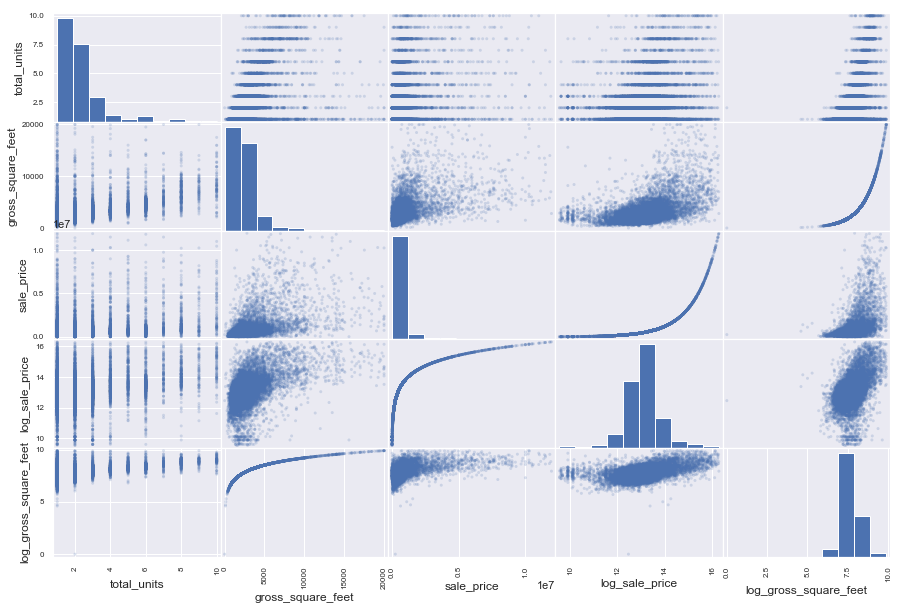

In [44]:
# check, hist, scatter b/w features

z = pd.plotting.scatter_matrix(raw_data, alpha=0.2, figsize=(15, 10))